<img src="ETSE.png" align="center" width="6800">
<br><br><br>
<font color="#CA3532"><h1 align="left">Diagramas de Influencia.</h1></font>
<font color="#6E6E6E"><h3 align="left">Modelos gráficos probabilísticos. Máster Oficial Ciencia Datos. UV.</h2></font> 

Antonio J. Serrano 

https://agrum.gitlab.io/pages/pyagrum.html

### Entorno MGP con conda (alternativa 1)

conda create -n MGP python=3.9

conda activate MGP 

conda install -c conda-forge pyagrum


(en windows, seguramente hará falta https://graphviz.org/download/)

### Entorno MGP con pip (alternativa 2)
pip install pyagrum

(instalar dependencias... pip install numpy scipy matplotlib pydotplus)

### Utilizar Google Colab (alternativa 3)

!pip install pyagrum

In [2]:
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

gum.config["influenceDiagram", "utility_show_stdev"] = False
#gum.config["influenceDiagram","utility_shape"] = "diamond"


# Ejemplo Médico 0. Sin posibilidad de acción.

Si no hay posibilidad de dar antibiótico, entonces asumimos que es equivalente a la acción no dar antibiótico. Calculamos el valor esperado de la utilidad.

In [3]:
prevalence = 0.14
U_X = [10, 3]
MEU = U_X[0] * (1 - prevalence) + U_X[1] * prevalence
MEU  #valor esperado medio de la utilidad

9.02

# Ejemplo Médico 1. Decisiones en completa Incertidumbre (con riesgo y sin información).

¿Es mejor dar antibiótico o no? Tenemos que tomar la decisión en base únicamente a la prevalencia de la enfermedad $P(X)$. ¿Por qué no hay un arco entre $X$ y $D$?

<img src="EjemploMedico2.png" width="50%">

Ejemplo de creación del diagrama de influencia.

"X->$U<-*D"

"X{+x|-x}->$U<-*D{+d|-d}" si queremos dar etiquetas a las variables

**Grafo/dependencias**

-   Añadimos relaciones con ->

-   Con ; añadimos más dependencias

**Tipos Nodos**

-   Probabilísticos (redondos). Tendremos que especificar DI.cpt("X")

-   Decisión (cuadrados) con el símbolo *

-   Utilidad (rombos) con el símbolo $. Tendremos que especificar DI.utility("U")

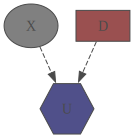

In [5]:
#DI=gum.fastID("X{+x|-x}->$U<-*D{+d|-d}")
DI = gum.fastID("X->$U<-*D")
#print(DI)
gnb.showInfluenceDiagram(DI)  #muestra el diagrama

Establecemos la probabilidad de la enfermedad $P(X)$ con DI.cpt("X").fillWith()

In [6]:
prevalence = 0.14
#solucion 
DI.cpt("X").fillWith([1 - prevalence, prevalence])

(pyAgrum.Potential<double>@0x6000037c4160) 
  X                |
0        |1        |
---------|---------|
 0.8600  | 0.1400  |

Establecemos la utilidad de la enfermedad $U(X,D)$ con DI.utility("U").fillWith()

In [7]:
#   +x=1 -x=0
# +d=1  8  9
# -d=0  3 10
# DI.utility("U")[0,0,:]=10
# DI.utility("U")[0,1,:]=3
# DI.utility("U")[1,0,:]=9
# DI.utility("U")[1,1,:]=8
U_DX = [10, 3, 9, 8]
#solucion

DI.utility("U").fillWith(U_DX)


(pyAgrum.Potential<double>@0x6000037c4260) 
             ||  U      |
X     |D     ||0        |
------|------||---------|
0     |0     || 10.0000 |
1     |0     || 3.0000  |
0     |1     || 9.0000  |
1     |1     || 8.0000  |

Utilzamos LIMID para resolver el diagrama de influencia, los resultados son los mismos que con el diagrama de influencia clasico.

_This inference considers the provided model as a LIMID rather than an influence diagram. It is an optimized implementation of the LIMID resolution algorithm. However an inference on a classical influence diagram can be performed by adding a assumption of the existence of the sequence of decision nodes to be solved, which also implies that the decision choices can have an impact on the rest of the sequence._

In [8]:
ie = gum.ShaferShenoyLIMIDInference(DI)
print(([list(DI.names())[i] for i in DI.topologicalOrder()]))
gnb.flow.row(ie.reducedLIMID(), ie.reducedGraph(), ie.junctionTree())

['U', 'X', 'D']


Inferenciamos (aunque no tenemos ningua evidencia).

In [9]:
ie.makeInference()  #inplace


Analizamos los resultados. Decisión óptima... 

In [10]:
ie.optimalDecision("D")


(pyAgrum.Potential<double>@0x6000037fd960) 
  D                |
0        |1        |
---------|---------|
 1.0000  | 0.0000  |

Valor esperado de la utilidad de cada Decisión. 

In [11]:
ie.posteriorUtility("D")

(pyAgrum.Potential<double>@0x6000014e0898) 
  D                |
0        |1        |
---------|---------|
 9.0200  | 8.8600  |

También podemos estudiar los nodos probabilísticos. 

In [12]:
ie.posterior("X")

(pyAgrum.Potential<double>@0x6000014e06f0) 
  X                |
0        |1        |
---------|---------|
 0.8600  | 0.1400  |

Finalmente el valor esperado medio de la utilidad. A este valor se le denomina Expected Value Without Information (EVwI) o similar.

In [13]:
#EVwPI
#solución

ie.MEU()  # mean expected utility

EVwI = ie.MEU()['mean']
EVwI


9.02

Visualmente... 

In [14]:
gnb.flow.row(ie.posterior("D"),
             ie.optimalDecision("D"),
             ie.posteriorUtility("D"),
             captions=['P(D|X)', 'Decisión Óptima', 'Valor de la decisión'])

Con estos datos podemos representar el diagrama de influencia resuelto. Utilizamos la función row de la libreria pyAgrum `gnb.flow.row(,,,)`

In [15]:
gnb.flow.row(DI, gnb.getInference(DI))



# Ejemplo Médico 2. Decisiones con información perfecta (sin riesgo).

¿Qué pasaría si fuéramos adivinos? Es decir, si dispusiéramos de la información perfecta. 

<img src="EjemploMedico1.png" width="50%">

Crea el nuevo diagrama. ¿Cuál es la decisión óptima? ¿Es siempre la misma? ¿Con qué valor? 

In [24]:
#DI=gum.fastID("X->$U<-*D;X->*D")
DI = gum.fastID("*D<-X->$U<-*D")
# DI
# nodo x
prevalence = 0.14
#solucion
DI.cpt("X").fillWith([1 - prevalence, prevalence])
# nodo u
U_DX = [10, 3, 9, 8]
DI.utility("U").fillWith(U_DX)
# creamos el juntion tree e inferiamos
ie = gum.ShaferShenoyLIMIDInference(DI)
ie.makeInference()
gnb.flow.row(ie.posterior("D"),
             ie.optimalDecision("D"),
             ie.posteriorUtility("D"),
             captions=['P(D|X)', 'Decisión Óptima', 'Valor de la decisión'])

Interpreta el diagrama de influencia resuelto. 

In [25]:
gnb.flow.row(DI, gnb.getInference(DI))


Valor esperado de disponer de la información perfecta (EV|PI) 

In [26]:
#EV_PI
#solucion
ie.MEU()  # mean expected utility

EV_PI = ie.MEU()['mean']
EV_PI

9.719999999999999

Expected Value of Perfect Information (EVPI)=EVPI=EV_PI-EVwI. Interpretación del EVPI
- Si EVPI es alto → La incertidumbre tiene un gran impacto en la decisión y obtener información adicional es muy valioso.
- Si EVPI es bajo → La mejor decisión es relativamente clara incluso sin información perfecta.
- Si EVPI es cero → Tener información adicional no cambia la decisión óptima.

In [31]:
#EVPI
#solucion
EVPI = EV_PI - EVwI
# EVPI

print(f"Valor esperado de la info perfecta: {EVPI:5.4f}")

Valor esperado de la info perfecta: 0.7000


# Ejemplo Médico 3. Decisiones con riesgo pero aportando información (normalmente por estimación). 

Hemos visto que disponer de información es bueno. ¿cómo la introducimos? Con un estimador (ej. modelo de aprendizaje máquina). 

<img src="EjemploMedico3.png" width="50%">

Crea el diagrama de influencia, X y U. 

In [43]:
#solucion
DI = gum.fastID("*D<-Y<-X->$U<-*D")
DI
# nodo x
prevalence = 0.14
#solucion
DI.cpt("X").fillWith([1 - prevalence, prevalence])
# nodo u
cost = 0.2
U_DX = [10, 3, 9, 8]
U_DX = [x - cost for x in U_DX]

DI.utility("U").fillWith(U_DX)
# creamos el juntion tree e inferiamos
ie = gum.ShaferShenoyLIMIDInference(DI)
ie.makeInference()
gnb.flow.row(ie.posterior("D"),
             ie.optimalDecision("D"),
             ie.posteriorUtility("D"),
             captions=['P(D|X)', 'Decisión Óptima', 'Valor de la decisión'])

Introduce la CPT del nodo Y sabiendo que la prueba tiene una Sensibilidad de 0.91 y un Especificidad de 0.97. 

In [53]:
se = 0.91
sp = 0.97
#solución

# PY_X =[[,],[,]] # заготовка
# PY_X = [[se, 1 - se], [1 - sp, sp]] # как выяснилось это криво
PY_X = [[sp, 1 - sp], [1 - se, se]]
# DI.cpt("X").fillWith([1 - se, se])
DI.cpt("Y")[:]=PY_X
DI.cpt("Y")


(pyAgrum.Potential<double>@0x6000037c88a0) 
      ||  Y                |
X     ||0        |1        |
------||---------|---------|
0     || 0.9700  | 0.0300  |
1     || 0.0900  | 0.9100  |

заготовка

Visualizarlo y recordar que lo que no es sensibilidad es uno menos la sensibilidad, lo que es especificidad. Soy docente que no es evidente. Hay que darle una vueltecita para que veáis que lo que estamos viendo

Fijaros que si es una tabla de probabilidad acondicionada, tiene que sumar uno, las filas o las columnas. Entonces, lo que es S, el contrario es 1 menos S, y lo que es SP es 1 menos SP. Estamos hablando en probabilidad, por eso lo del porciento en este caso no es una probabilidad. Así, 1 menos S, 1 menos SP.

Про кривоту
La sensibilidad es cuando realmente es uno y yo predigo que es uno. Esto es la I y esto es la X. Esto es la realidad, por lo tanto, la sensibilidad es la sensibilidad es A partido... Por lo tanto, este de aquí es el que tiene que ser 0.91. Y es donde los dos son unos. Aquí tiene que estar el 0.91. O sea, donde está este, tiene que estar la sensibilidad. A ver, yo sé que esto, Pablo, el lunes por la mañana, cuando empieza a unir toda la fija, pues... Ya sabemos cómo se hace para siempre, ¿vale? Esto lo tenemos que recordar todos.
Pero he aprendido a que si pones esto, esto se lo reestructura como toca para que tenga las dimensiones adecuadas, ¿no? Entonces, si pones esto, directamente lo coge. Ahora, ¿está en su sitio cada cosa?




Resuelve e interpreta el diagrama de influencia.

In [54]:
ie = gum.ShaferShenoyLIMIDInference(DI)
ie.makeInference()
gnb.flow.row(DI, gnb.getInference(DI))

Determina la probabilidad de Y=1 sabiendo que X=0. Para introducir evicencias se utiliza el método setEvidence ie.setEvidence({'X':0}). ¿Cuál es el valor esperado? ¿Cómo puede ser mayor que el EV_PI?

In [55]:
#solución
ie.setEvidence({"X":0})
ie.makeInference()
ie.posterior("Y") # como x=0 entonces acertara segun la especifidad de la prueba

print(f"el valor esperado es :{ie.MEU()['mean']:5.4f}")


el valor esperado es :9.8000


Observa cómo cambia la decisión óptima cuando Y=1 y Y=0.

In [58]:
#solución
# gnb.flow.row(gnb.getInference((DI, evs={'X':'0'})


SyntaxError: invalid syntax (2028490902.py, line 2)

# Ejemplo Médico 4. Decisiones con riesgo pero aportando información y pagando por ella (coste de la estimación).

Nota: 

Para indicar que no hay estimación de X a partir de Y se puede realizar de dos maneras:
* Añadiendo una salida más a Y (ej. nr) para indicar que no hay respuesta [preferible]
* Utilizando una distribución de probabilidad no informativa (en este caso 1/2) para que D no tenga información de X (el nodo Y marea X para que D no tenga información privilegiada)

El arco de predecencia T->D no aporta nada en este ejercicio porque D recibe la información a través de Y

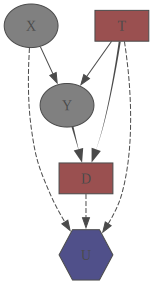

(pyAgrum.Potential<double>@0x6000037d9720) 
  X                |
+x       |-x       |
---------|---------|
 0.1400  | 0.8600  |

In [70]:
# DI = gum.fastID("X{-x|+x}->$U<-*D{+d|-d};X->Y{+y|-y|nr}->*D;Y<-*T{+t|-t}->$U;*T->*D")
DI = gum.fastID("X{+x|-x}->$U<-*D{+d|-d};X->Y{+y|-y|nr}->*D;Y<-*T{+t|-t}->$U;*T->*D")
#DI=gum.fastID("X{+x|-x}->$U<-*D{+d|-d};X->Y{+y|-y|nr}->*D;Y<-*T{+t|-t}->$U")
#DI=gum.fastID("X[2]->$U<-*D[2];X->Y[3]->*D;Y<-*T[2]->$U;*T->*D")
gnb.showInfluenceDiagram(DI)
#solución
prevalence = 0.14
DI.cpt("X").fillWith([prevalence, 1-prevalence])

Valor Esperado de Test

In [71]:
cost = 0.2
U_DX = [10, 3, 9, 8]
U_DX = [8-cost, 9-cost, 3-cost, 10-cost, 8,9,3,10]
DI.utility("U").fillWith(U_DX)

(pyAgrum.Potential<double>@0x6000037da560) 
                    ||  U      |
X     |D     |T     ||0        |
------|------|------||---------|
+x    |+d    |+t    || 7.8000  |
-x    |+d    |+t    || 8.8000  |
+x    |-d    |+t    || 2.8000  |
-x    |-d    |+t    || 9.8000  |
+x    |+d    |-t    || 8.0000  |
-x    |+d    |-t    || 9.0000  |
+x    |-d    |-t    || 3.0000  |
-x    |-d    |-t    || 10.0000 |

Valor Esperado de Test y Resultado de la prueba Y

In [ ]:
se=0.91
sp=0.97
DI.cpt("Y")[{'T:'+t'}]

--
DI=gum.fastID("*D<-X->$U<-*D")
Y si estoy enfrentado sí que doy antiguidad. Entonces la utilidad de la decisión de 0 es 10, que es la máxima, y la utilidad es 8. Y probabilísticamente, esto es lo realmente curioso de las veces, ¿lo veis? La decisión óptima no es siempre ya la misma. Es copiar lo de arriba, analizar lo de abajo, ahora lo vuelvo a poner. Pues que el nodo aleatorio sigue siendo lo que habíamos puesto nosotros de la prevalencia, no tiene padre ni nada, nada le afecta a él.

Pero ahora, cuando le calculáis el nodo de utilidad, el nodo de decisión, y lo resumís en solo sus dos valores, aquí tiene que especificar que no siempre toma la decisión igual. Entonces, no siempre es el 100% cero de las veces, sino ni el de otro. Y qué casualidad que coinciden las probabilidades de esa decisión con las probabilidades de la infección. Voy a calcular el valor esperado y mirar esto. Si el valor esperado de la información, si es muy alto, significará que obtener información es()_ muy importante. Si es muy bajo, significa que obtener más información no vale para nada. Y si es cero, significa que la información no ha aportado nada. Recordad que esto es la copia de arriba, no ha añadido nada nuevo.


--gnb.flow.row(DI,gnb.getInference(DI))
Y luego el otro que le hemos calculado. Entonces aquí lo tenéis todo resuelto. La decisión óptima al 100% es esto, con tal valor esperado, y probabilísticamente estamos infectados al 14% y el valor esperado. Por lo tanto, en realidad solo tenemos que hacer esta línea aquí. Una vez que creamos el grafo, le ponemos al línea y ya está todo.

EVwPI
Los economistas a este valor, que lo hemos obtenido sin ninguna información, se le llama... ¿Cómo lo llamáis vosotros? Es el valor esperado de no tener ninguna información. Algunos le llaman así, por los tres o cuatro libros cada uno le llama de una forma. Lo importante es que veáis que en realidad que tenemos claro. Hemos tomado una decisión, solamente, pero además es una decisión, que no lo he dicho, pero está en el título, por riesgo, porque en el momento en que hay elementos aleatorios, en el mundillo de la toma de decisiones, se le llama tomar decisiones por riesgo.

Es lo diferente de cuando haces programación lineal, que es encontrar la mejor solución dada esta preciosa decisión, es totalmente optimista. Tú sabes qué máquinas necesitas, con qué restricciones, qué no sé qué. Un momento que hay un elemento aleatorio, ya se le llama toma de decisiones con riesgo. O con incertidumbre, dependiendo, no sé qué. Entonces, al valor esperado de esto, se le llama, vamos a guardarlo para después. Os lo enseño primero aquí. Cuando pones esto es porque llamas a una función. Pero normalmente cuando pones punto... Porque si no fuera una función sería la propiedad... Tenía que pensarlo. Pues venga, va. Sacarle este valor y lo guardáis en... De una para otra vez. Vale. Pues supongo yo que está bien guardadito. Por el caso... y la T viene de diferentes informes.

--
 Ejemplo Médico 1
Lo recuerdo. El valor esperado de una variable aleatoria es simplemente la probabilidad de cada valor multiplicado por el propio valor. Suponiendo que sea de una función de la variable aleatoria, pues entonces es el valor, la probabilidad de la variable aleatoria por el valor que coge esa variable aleatoria. Entonces, ¿cuál es el valor esperado de la utilidad si no podemos hacer nada? ¿Cuál es el valor esperado de la utilidad?

Si no puedo hacer nada, es como si no doy antibiótico. ¿Cuál sería el valor esperado? Sería la probabilidad de estar infectado más la probabilidad de no estar infectado, donde esto es la utilidad de no estar infectado 3 por 0.14 más 10 por lo contrario de 0.14. ¿Por qué se suele calcular esto? Porque viene a ser una medida base de, si yo no hago nada, ya sé valorar mi no acción, cuánto valor tiene. ¿En el que sale? No, creo que está puesto en el propio jodido.

--
Ejemplo Médico 0. Sin posibilidad de acción.
Un valor de... esto lo quito ya... 902. 902 unidades de lo que sea, ¿vale? De calidad de vida del paciente. Entonces, recordad que estos son valores relativos. Por lo tanto, nos interesa saber sobre qué niveles nos estamos volviendo. Voy a llevar una matriz, fijaros que la utilidad depende de X, en este caso solo depende de X. Ahora ya vamos a este esquema de aquí.

--
Establecemos la probabilidad de la enfermedad $P(X)$ con DI.cpt("X").fillWith()
Os he enseñado la parte fácil. ¿Os acordáis del model string del BNLF? Pues este lo tiene todavía más fácil. Directamente ponéis los arcos hacia donde queréis. Le ponéis un dólar y el nodo de utilidad, y le ponéis un asterisco y el nodo de difícil. Os lo sumo. Además, os lo explico por ahí. Si quisiéramos añadir más cosas, entonces ponemos punto y coma y ponemos más altos. Punto y coma. Entonces, si lo lanzáis...

Por cierto, esto es... Podéis poner para cada variable qué etiquetas tiene, ¿vale? Y luego, si le ponéis un corchecker, podéis decirle cuántos valores quiere y que lo pongan solo, como aquí, ¿vale? Entonces, si aquí estoy a tres valores, y al igual que hacíamos con la red baesiana, esto hay que ir alimentando. Cada nodo le tenemos que decir qué es lo que queremos ver. Lo primero es ponerle qué casualidad se le llama CT.

Copiamos esto, lo ponemos abajo. ¿Qué ponemos? Pues esto que es la primera parte, como es el cero, ¿no? Es uno menos la prevalencia. Esto no sé si lo tenéis. ¿Os han dicho que pongáis el codium este? ¿Vale? ¿Os lo ha dicho Marcelino o Juan? Esto es una broma. Esto en realidad me lo dijo a mí un alumno. ¿Vale? Yo creo que por ser de la universidad también tenemos el copilot de este. Pero con eso de que tienes que decirle lo que quiere, es que este te lo adivina. ¿Vale? ¿Vale? Pues nada, ya lo tenemos. ¿Vale? Os ha salido esto. 086, 014. ¿Vale? ¿Y qué casualidad? Bueno, la decisión no tenemos que poner nada porque va a ser siempre decisión óptima.

--
Establecemos la utilidad de la enfermedad $U(X,D)$ con DI.utility("U").fillWith()
Esto en realidad se puede meter así. Si sois suficientemente pacientes, dándole valores a qué tal fila, qué color, en múltiples dimensiones, consigues meterlo, ¿vale? Pero yo lo he arreglado ya para que si lo metéis directamente se os cargue. Esto está bien, ¿no? Si no, damos 0, 3. Y si damos 10, 3. 9, 8. Y nada, vais a ver que esto un botoncito y lo hace solo.

--
ie=gum.ShaferShenoyLIMIDInference(DI)
ste y este es el J.T. que tenemos aquí, y este es el J.T. que tenemos aquí, y este que tenemos antes en el modelo paesiano J.T. En granjo está muy bien, pero ahora cuando yo quiero pásamelo a otra cosa... ¿Qué era esto? Esto en realidad es el J.T. que ha sacado. Pasamos. inspiredbyguy Sims


--
Analizamos los resultados. Decisión óptima...
Y ya está. Aquí os pongo que es in play porque lo hace intricamente. Y ahora ya podemos preguntarle cosas. Oye, ¿cuál es la decisión última? Me lo dice. Tú deberías... no da antibiótico, lo veo. Y le puedo decir, oye, ¿me puedes decir por qué? ¿Cuál es la utilidad de cada uno de ellos? Y me sale 902 y 886, que debería ser lo que tenía aquí. 886 y 902. Entonces me dice, fenomenal. Y ahora puedes calcular cualquier otra cosa. Que si la probabilidad posterior del nodo que sea... Y ahora aquí vienen los churros. Y ahora...

--
ie.setEvidence({"X":0})
Entonces, como esto es como un árbol de unión, ¿vale? En el momento en que metemos la evidencia, aquí nos obligan a hacer otra vez la inferencia. Y nada, vemos que seguro que no está infectado. La marginal ley. Y ahora me sale otra cosa como acertará según la especificidad de la prueba. No es lo que habíamos dicho. La especificidad es acertar un 97%, que es lo que es. Si yo calculo el valor esperado,


print(f"el valor esperado es :{ie.MEU()['mean']:5.4f}")
Cómo puede ser que sea mayor que el valor máximo de la utilidad? Hemos dicho que era 0.72, ¿acordáis? Haga que el esquema tenga más que cuando estábamos antes aquí, ¿acordáis? Esto es lo que más valor tenía. Pero yo no sabía lo que valía X. Y ahora, de repente, este esquema que es mucho más complicado, cuando es el valor de X, esto vale más. El ejemplo de antes era el valor medio de ambos casos. Entonces, tenemos mejor definido el caso en el cual uno está infectado, que si en el caso en el que está infectado quedaría un valor más bajo.

En el fondo es que no son comparables. Es un poco lo que estabas diciendo. Cuando estás en la información perfecta, tú tienes una incertidumbre igual. Es verdad que tienes mucha información, pero el nodo aleatorio sigue siendo aleatorio. Aquí ya no tienes una aleatoriedad. Lo que pasa es que tu prueba no es perfecta, pero la aleatoriedad ya no la tienes. Entonces, como estás en un entorno sin incertidumbre, estás jugando unas condiciones, digamos, ventajosas.


Observa cómo cambia la decisión óptima cuando Y=1 y Y=0.
Mira que bonito que sale. Lo meto aquí por el medio. Se puede hacer directamente así. Le dices, oye, quiero la inferencia del diagrama, pero le pones tal evidencia. Cuando un cuadradito se pone naranja, significa que eso lo sabe ya. Directamente, pones aquí lo que quieras y te lo calcula. Y sale lo mismo, ¿lo ves? Posiblemente hacéis vosotros los dos siguientes. ¿Qué es esto? Mirar cómo cambia la decisión cuando la prueba da positiva o cuando la prueba da negativa. Y compararlo con esto aquí. Bueno, hacerlo así, con este...

----

Ejemplo Médico 4
Para que podáis después hacer un diagrama de cómo toca en una presentación. Ya os he puesto el dibujito y os he explicitado la preferencia de esta. Si nos da tiempo veremos que si lo quitamos sale exactamente lo mismo, pero por si acaso lo pongo y así no ocala en lugar. Entonces nada, montarlo. Resolverlo. ¿Tenéis todo? De hecho el nodo X es el mismo, el nodo Y es el mismo. Ahora cuidado con el nodo U, porque el nodo U depende de si tienes T o no tienes T. Vale, una matriz u otra. ¿Vale?


Como lleva más x y menos x, ¿no? ¿Qué es lo que pasa? Pues que ahora ya no va en este orden, va en el orden contrario. Por eso quería que ahora lo hiciéramos con si cambias aquí el orden, cambia aquí también. A mí estoy tonto, macho. Bueno, ¿qué hacemos? ¿Cambiamos aquí o arriba? ¿Qué os parece más lógico? ¿-X más X más X? Imagina después para interpretar la sensibilidad de todo esto, pero bueno. Con esto, con la utilidad, porque ahora la utilidad tiene más valores, ¿lo veis? Tiene si es la prueba o si no es la prueba. Me he peleado con la utilidad. Si la T es positiva...

Y así mañana ya podemos... Os da tiempo a repasarlo y ya mañana solo nos queda...

En realidad, la única diferencia con la que teníamos antes es que ahora nuestro modelo va a tener salida positiva o no responde. No responde, dependerá de si hay pruebas. Si hay pruebas. Entonces, rellenamos la equis, que es neutralatorio, a base de utilidad, que depende de si hacemos test o no. Y la salida tiene un T positivo, sigue siendo el mismo valor de antes, pero lo importante es este cero.

Este cero es que la no responde si tiene probabilidad. Y si es que sí, y si no hacemos el test, entonces no responde con probabilidad. De esa forma, cuando hacéis esto, esta es otra forma de hacerlo. Antes le habíamos puesto gaming friendly, pero ahora puedes decirle, oye, quiero que sea sobre esta game entry. ¿Vale? Por si acaso queréis diferentes, también se le puede poner. Y mira lo que sale. Sabe que siempre hay que hacer el test al 100%.

Esto será lo que le vamos a dar a la computadora. No olvides de escuchar. Y aquí vemos lo de siempre. En este caso, al siempre ser que sí, si, pero le damos caso al modelo, explota su promedio de 2K, de un marginal o lo que sea, y al final nos sale... ¿Qué nos ha salido? El 943 que era el del esquema anterior. Pero nos podía haber salido el 902 o por debajo del otro, que veía aquí el 992, y va a salir esto.

Buah, es que esto siempre sale. No me lo puedo recordar en una tesis que lo comprobé, sale que el modelo no sale y encima a coste cero. Es decir, sin pagar nada por él, no interesa hacerlo frente a lo que ya tienes previamente porque hay veces que el que tú te equivoques tiene tantísima penalización. Si hacéis esto con el modelo ese de las setas, te sale que es que no vale para nada. Entonces, aunque se te escapara el detallito ese de que es posible envenenar a la gente, pones esto y te sale bien. El modelo ya puede tener la sencillez, la especificidad que quieras, que no funciona. Entonces, lo subo, repasar,